# Todo

- Handle Zeroes in re74, re75 and re78

In [25]:
%matplotlib inline

In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [27]:
DATA = './data/'

# Exercise 1: Propensity Score Matching

Black and Hispanic people will further be considered as minorities. A column is added to the lalonde dataframe.

In [28]:
lalonde = pd.read_csv(DATA + 'lalonde.csv')
lalonde['minority']=lalonde['black']+lalonde['hispan']
lalonde = lalonde[lalonde.re78 != 0.0]
#lalonde[(lalonde.re78 != 0.0) & (lalonde.treat == 0)].shape

### 1.1 A naive analysis

In this first naive analysis we seperate the data into two groups, where the first group received treatment and the second group did not receive treatment. We compare these groups solely by the real earnings of the subjects in 1978. 

#### 3 plots are shown below:


- In the first plot on the left the cumulative distribution function of the real earnings of treated and untreated subjects is shown in overlay. The two CDFs look quite similar.


- On the plot in the middle, the normalized histogram is shown. The way the earnigns of the treated and the non treated subjects is distributed further confirms, that naively plotting these histograms seems to imply, that there is no difference between the two groups, when looking at their real earnings in 1978.


- In the third plot the number of subjects per bin is visible. In this plot it becomes apparent, that the sizes of the groups are very different and that a naive approach can lead to misleading conclusions.

In [29]:
treated = lalonde[(lalonde.treat == 1) & (lalonde.re78 != 0.0)]
non_treated = lalonde[(lalonde.treat == 0) & (lalonde.re78 != 0.0)]

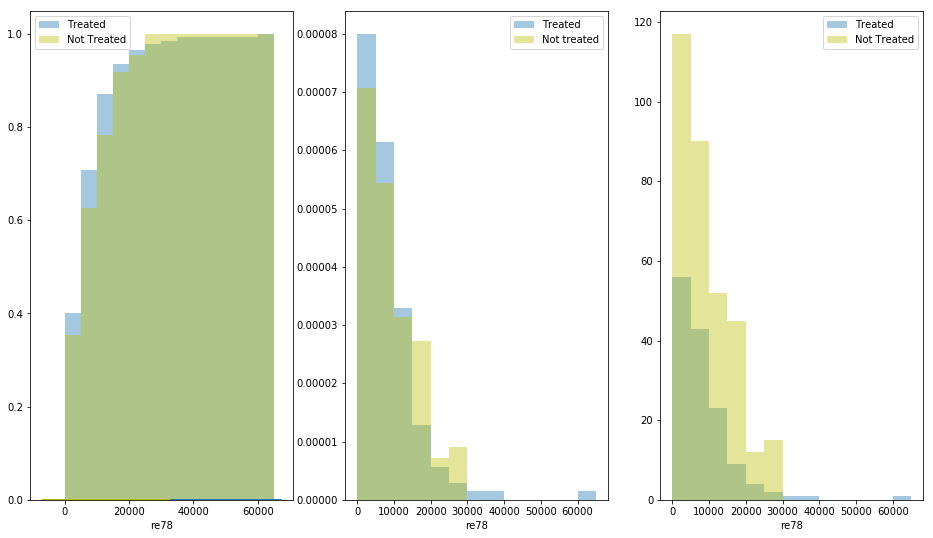

In [30]:
bins = np.arange(0, 70000, 5000)

fig, axs = plt.subplots(1, 3, figsize=(16, 9))

sns.distplot(treated.re78, bins=bins, hist_kws=dict(cumulative=True), ax=axs[0],label='Treated')
sns.distplot(non_treated.re78, bins=bins, hist_kws=dict(cumulative=True), ax=axs[0], color='y', label = 'Not Treated')
axs[0].legend()

sns.distplot(treated.re78, bins=bins, norm_hist=True, kde=False, ax=axs[1],label='Treated')
sns.distplot(non_treated.re78, bins=bins, norm_hist=True, kde=False, ax=axs[1], color='y',label ='Not treated')
axs[1].legend()

sns.distplot(treated.re78, bins=bins, kde=False, ax=axs[2],label='Treated')
sns.distplot(non_treated.re78, bins=bins, kde=False, ax=axs[2], color='y',label = 'Not Treated')
axs[2].legend()

### 2. A closer look at the data


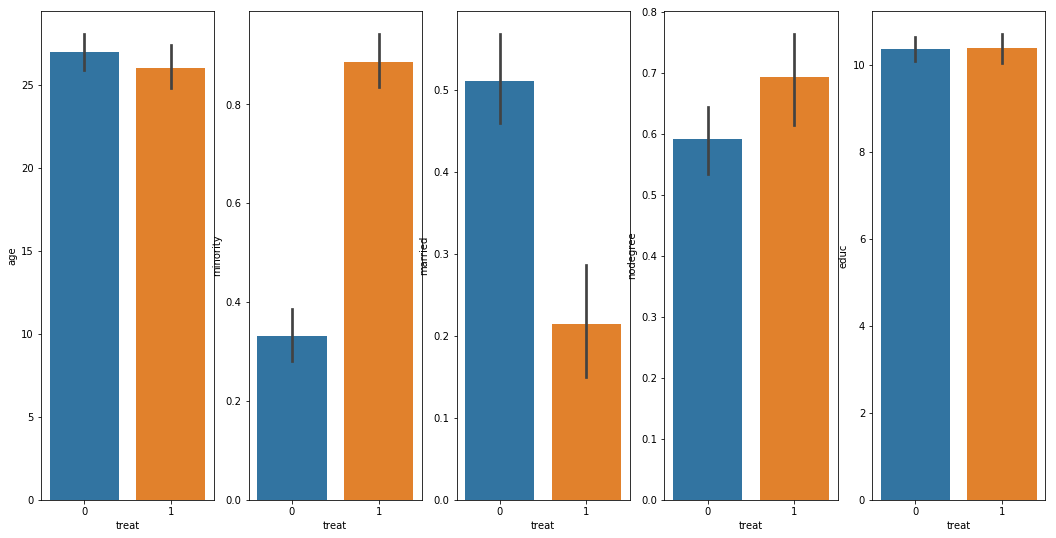

In [31]:
fig, axs = plt.subplots(1, 5, figsize=(18, 9))
sns.barplot(x = 'treat', y='age', data = lalonde,ax = axs[0])
sns.barplot(x = 'treat',y ='minority', data = lalonde,ax = axs[1])
sns.barplot(x = 'treat',y ='married', data = lalonde,ax = axs[2])
sns.barplot(x = 'treat',y ='nodegree', data = lalonde,ax = axs[3])
sns.barplot(x = 'treat',y ='educ', data = lalonde,ax = axs[4])

From the above plots it becomes clear, that the subjects chosen for the treatment were not chosen randomly. They are on average younger, less likely to be married, have less degrees and are overwhelmingly either black or hispanic. Only the number of years of education is similar, but this is not surprising, because the regular number of years of education in the United States is 12.


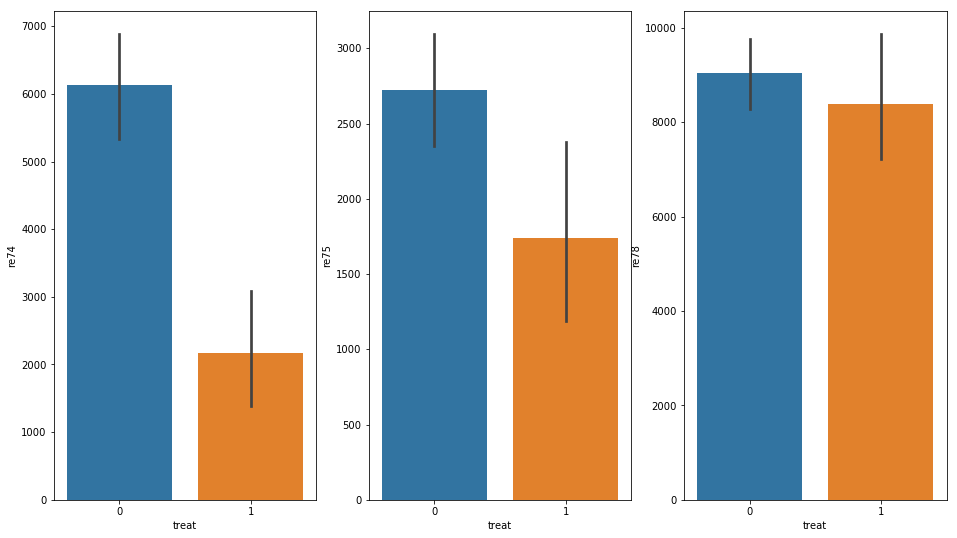

In [32]:
fig, axs = plt.subplots(1, 3, figsize=(16, 9))
sns.barplot(x = 'treat', y='re74', data = lalonde,ax = axs[0])
sns.barplot(x = 'treat',y ='re75', data = lalonde,ax = axs[1])
sns.barplot(x = 'treat',y ='re78', data = lalonde,ax = axs[2])